# Применение линейной регрессии на примере прогнозирования роста человека по его весу

Будем использовать данные [SOCR](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_Dinov_020108_HeightsWeights) по росту и весу 25 тысяч подростков.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('weights_heights.csv', index_col='Index')
data.head()

,Height,Weight
Index,,
1,65.78331,112.9925
2,71.51521,136.4873
3,69.39874,153.0269
4,68.21660,142.3354
5,67.78781,144.2971


Построим гистограмму распределения роста и веса подростков из выборки. 

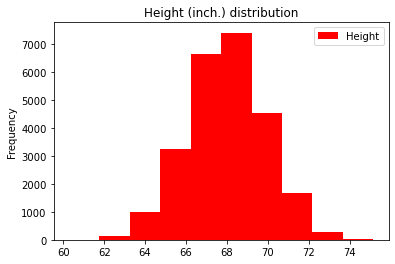

In [3]:
data.plot(y='Height', kind='hist', 
           color='red',  title='Height (inch.) distribution')

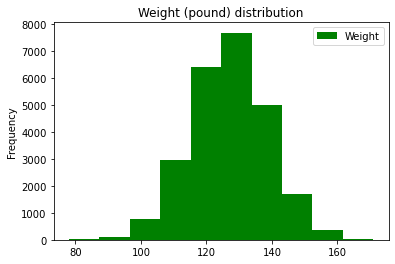

In [4]:
data.plot(y='Weight', kind='hist', 
           color='green',  title='Weight (pound) distribution')

Добавим третий признак. Создадим признак *Индекс массы тела* ([BMI](https://en.wikipedia.org/wiki/Body_mass_index)). 

In [5]:
def make_bmi(height_inch, weight_pound):
    METER_TO_INCH, KILO_TO_POUND = 39.37, 2.20462
    return (weight_pound / KILO_TO_POUND) / \
           (height_inch / METER_TO_INCH) ** 2

In [6]:
data['BMI'] = data.apply(lambda row: make_bmi(row['Height'], 
                                              row['Weight']), axis=1)

Построим картинку, на которой будут отображены попарные зависимости признаков , 'Height', 'Weight' и 'BMI' друг от друга. 

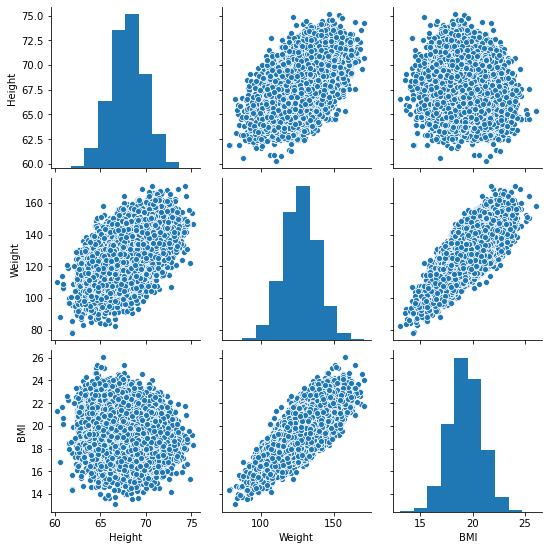

In [7]:
sns.pairplot(data)

Добавим новый признак *weight_category*, который будет иметь 3 значения: 1 – если вес меньше 120 фунтов. (~ 54 кг.), 3 - если вес  больше или равен 150 фунтов (~68 кг.), 2 – в остальных случаях. Визуализируем с помощью графика boxplot

Text(0.5, 0, 'Весовая категория')

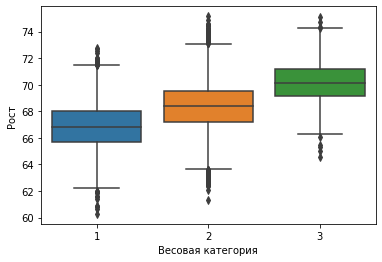

In [8]:
def weight_category(weight):
    if weight < 120:
        return 1
    if weight >= 150:
        return 3
    else:
        return 2

data['weight_cat'] = data['Weight'].apply(weight_category)
ax = sns.boxplot(x="weight_cat", y="Height", data=data)
plt.ylabel('Рост')
plt.xlabel('Весовая категория')

Построим scatter_plot зависимости роста человека от веса 

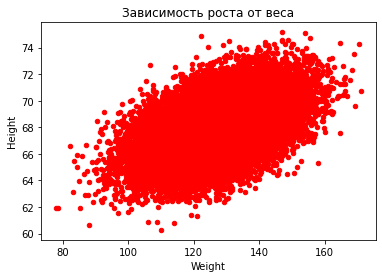

In [9]:
data.plot(y='Height', x='Weight', kind='scatter', 
           color='red',  title='Зависимость роста от веса')
# У чувака кровь пошла из носа, и он просит тридцатку? (с) 1+1

## Минимизация квадратичной ошибки

В простейшей постановке задача прогноза значения вещественного признака по прочим признакам (задача восстановления регрессии) решается минимизацией квадратичной функции ошибки. 

Напишем функцию, которая по двум параметрам $w_0$ и $w_1$ вычисляет квадратичную ошибку приближения зависимости роста $y$ от веса $x$ прямой линией $y = w_0 + w_1 * x$:
$$error(w_0, w_1) = \sum_{i=1}^n {(y_i - (w_0 + w_1 * x_i))}^2 $$
Здесь $n$ – число наблюдений в наборе данных, $y_i$ и $x_i$ – рост и вес $i$-ого человека в наборе данных. 

In [10]:
def error(w0, w1):
    n = data.shape[0] #  data.shape[0] - число строк, то есть число наблюдений 
    error = 0
    for i in range(1, n+1): 
        error += (data['Height'][i]-(w0+w1*data['Weight'][i]))**2
    return error

Итак, мы решаем задачу: как через облако точек, соответсвующих наблюдениям в нашем наборе данных, в пространстве признаков "Рост" и "Вес" провести прямую линию так, чтобы минимизировать функционал из п. 6. Для начала отобразим произвольные прямые и убедимся, что они плохо передают зависимость роста от веса.

Проведем две прямые, соответствующие значениям параметров ($w_0, w_1) = (60, 0.05)$ и ($w_0, w_1) = (50, 0.16)$. 

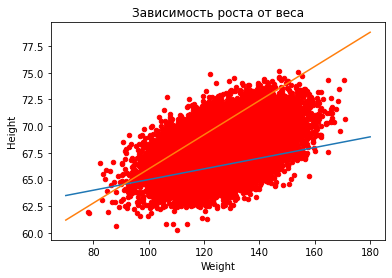

In [11]:
data.plot(y='Height', x='Weight', kind='scatter', 
           color='red',  title='Зависимость роста от веса')
x = np.linspace(70, 180)
y1 = 60+0.05*x
y2 = 50+0.16*x
plt.plot(x, y1,  x, y2)

Минимизация квадратичной функции ошибки - относительная простая задача, поскольку функция выпуклая. Для такой задачи существует много методов оптимизации. Посмотрим, как функция ошибки зависит от одного параметра (наклон прямой), если второй параметр (свободный член) зафиксировать.

Построим график зависимости функции ошибки от параметра $w_1$ при $w_0$ = 50. 

Text(0.5, 1.0, 'Зависимость функции ошибки от w1')

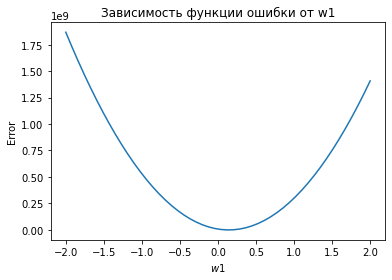

In [12]:
w1 = np.linspace(-2,2)
er = [error(50,w) for w in w1]
plt.plot(w1, er)
plt.ylabel('Error')
plt.xlabel('$w1$')
plt.title('Зависимость функции ошибки от w1')

Теперь методом оптимизации найдем "оптимальный" наклон прямой, приближающей зависимость роста от веса, при фиксированном коэффициенте $w_0 = 50$.

С помощью метода *minimize_scalar* из *scipy.optimize* найдем минимум функции для значений параметра  $w_1$ в диапазоне [-5,5]. Проведем на графике прямую, соответствующую значениям параметров ($w_0$, $w_1$) = (50, $w_1\_opt$), где $w_1\_opt$ – найденное оптимальное значение параметра $w_1$. 

In [13]:
from scipy.optimize import minimize_scalar
min = minimize_scalar(lambda w1: error(50,w1),bounds=(-5,5))
print('Минимальное значение функции:', min.fun)
print('Оптимальное значение параметра w1:', min.x)

Минимальное значение функции: 79512.21728699486
Оптимальное значение параметра w1: 0.14109203728834385


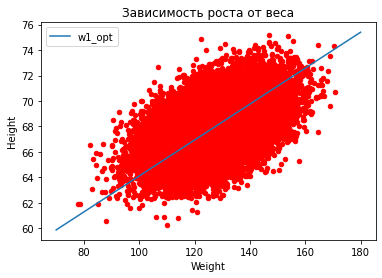

In [14]:
data.plot(y='Height', x='Weight', kind='scatter', 
           color='red',  title='Зависимость роста от веса')
x = np.linspace(70, 180)
y = 50+min.x*x
plt.plot(x, y, label='w1_opt')
plt.legend()

Построим 3D-график зависимости функции ошибки, посчитанной от параметров $w_0$ и $w_1$.

In [15]:
from mpl_toolkits.mplot3d import Axes3D

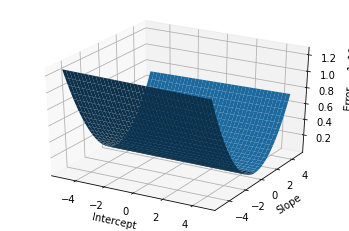

In [16]:
fig = plt.figure()
ax = fig.gca(projection='3d') 

# Создаем массивы NumPy с координатами точек по осям X и У. 
# Используем метод meshgrid, при котором по векторам координат 
# создается матрица координат. Задаем нужную функцию Z(x, y).
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
Z = error(X,Y)

# Используем метод *plot_surface* объекта 
# типа Axes3DSubplot. Также подписываем оси.
surf = ax.plot_surface(X, Y, Z)
ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')
ax.set_zlabel('Error')
plt.show()

Найдем минимум функции ошибки для значений параметра $w_0$ в диапазоне [-100,100] и $w_1$ - в диапазоне [-5, 5]. Начальная точка – ($w_0$, $w_1$) = (0, 0). Используем метод оптимизации L-BFGS-B.

In [17]:
from scipy import optimize
def error_one_parametr(w):
    n = data.shape[0] 
    error = 0
    for i in range(1, n+1):  
        error += (data['Height'][i]-(w[0]+w[1]*data['Weight'][i]))**2
    return error
minimum = optimize.minimize(error_one_parametr, [0, 0], method='L-BFGS-B', bounds = ([-100,100],[-5,5]))
print('Минимальное значение функции:', minimum.fun)
print('Оптимальное значение параметра w0:', minimum.x[0])
print('Оптимальное значение параметра w1:', minimum.x[1])

Минимальное значение функции: 67545.28709427758
Оптимальное значение параметра w0: 57.57190153837173
Оптимальное значение параметра w1: 0.08200545980757475


Проведем прямую, соответствующую найденным оптимальным значениям параметров $w_0$ и $w_1$. 

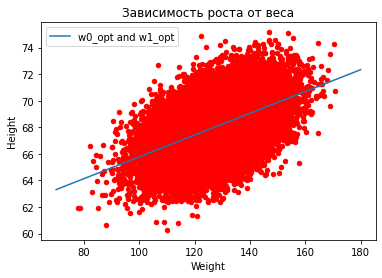

In [18]:
data.plot(y='Height', x='Weight', kind='scatter', 
           color='red',  title='Зависимость роста от веса')
x = np.linspace(70, 180)
y = minimum.x[0]+minimum.x[1]*x
plt.plot(x, y, label='w0_opt and w1_opt')
plt.legend()